## Amazon Rekognition Video : People Pathing

In this workshop we will explore what we just reviewed on Amazon Rekognition Video capabilities for stored video. We will look at 

1. Set up , Permissions
2. Steps involved 
3. People Pathing API 
4. Results 
5. Post Processing and Analysis

Note that what we demonstrate here can quickly be complied into a lambda function that can continue to keep track of the job and alert or process the results when rekognition is done. However for tutorial purposes, we will do this in notebook for immediate rendering of output and results.

The purpose of use the API in reference is to measure engagement and faces provide the best measure of engagement. The API we will look at in the next workshop is people pathing API, so we can track individuals across the length of the video

#### Let's start with some basic libraries 

In [18]:
import boto3
import json
import logging
import sys


In [19]:

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
rek=boto3.client('rekognition')

#### Convenience Functions

I have created come convenience functions here modified from documentation for the sake of this workshop, these can also be used inside lambda functions with minor modifications

we have functions here to 

1. create a notification channel (SNS, SQS, IAM Role)
2. Poll Notification Channel for job completion 
3. get results from the rekognition after the completion of the job 
4. upload a file to s3 in json format
5. delete resources created by step 1

In [20]:
def create_notification_channel(resource_name):
    """
    Creates a notification channel used by Amazon Rekognition to notify subscribers
    that a detection job has completed. The notification channel consists of an
    Amazon SNS topic and an Amazon SQS queue that is subscribed to the topic.

    After a job is started, the queue is polled for a job completion message.
    Amazon Rekognition publishes a message to the topic when a job completes,
    which triggers Amazon SNS to send a message to the subscribing queue.

    As part of creating the notification channel, an AWS Identity and Access
    Management (IAM) role and policy are also created. This role allows Amazon
    Rekognition to publish to the topic.

    :param resource_name: The name to give to the channel resources that are
                          created.
    :param iam_resource: A Boto3 IAM resource.
    :param sns_resource: A Boto3 SNS resource.
    :param sqs_resource: A Boto3 SQS resource.
    """
    print("Creating notification channel from Amazon Rekognition to Amazon SQS.")
    iam_resource = boto3.resource('iam')
    sns_resource = boto3.resource('sns')
    sqs_resource = boto3.resource('sqs')

    topic = sns_resource.create_topic(Name=resource_name)
    queue = sqs_resource.create_queue(
        QueueName=resource_name, Attributes={'ReceiveMessageWaitTimeSeconds': '5'})
    queue_arn = queue.attributes['QueueArn']

    # This policy lets the queue receive messages from the topic.
    queue.set_attributes(Attributes={'Policy': json.dumps({
        'Version': '2008-10-17',
        'Statement': [{
            'Sid': 'test-sid',
            'Effect': 'Allow',
            'Principal': {'AWS': '*'},
            'Action': 'SQS:SendMessage',
            'Resource': queue_arn,
            'Condition': {'ArnEquals': {'aws:SourceArn': topic.arn}}}]})})
    topic.subscribe(Protocol='sqs', Endpoint=queue_arn)

    # This role lets Amazon Rekognition publish to the topic. Its Amazon Resource
    # Name (ARN) is sent each time a job is started.
    try:
        role = iam_resource.create_role(
            RoleName=resource_name,
            AssumeRolePolicyDocument=json.dumps({
                'Version': '2012-10-17',
                'Statement': [
                    {
                        'Effect': 'Allow',
                        'Principal': {'Service': 'rekognition.amazonaws.com'},
                        'Action': 'sts:AssumeRole'
                    }
                ]
            })
        )
        policy = iam_resource.create_policy(
            PolicyName=resource_name,
            PolicyDocument=json.dumps({
                'Version': '2012-10-17',
                'Statement': [
                    {
                        'Effect': 'Allow',
                        'Action': 'SNS:Publish',
                        'Resource': topic.arn
                    }
                ]
            })
        )
        role.attach_policy(PolicyArn=policy.arn)
    except Exception as e:
        print(e)
    return {'RoleArn': role.arn, 'SNSTopicArn': topic.arn}, {'Role':role,'queue':queue, 'topic':topic}


def delete_notification_channel(resource_dict):
    """
    Deletes all of the resources created for the notification channel.

    """
    role=resource_dict['Role']
    topic=resource_dict['topic']
    queue=resource_dict['queue']
    for policy in role.attached_policies.all():
        role.detach_policy(PolicyArn=policy.arn)
        policy.delete()
    role.delete()
    print("Deleted role %s.", role.role_name)
    role = None
    queue.delete()
    print("Deleted queue %s.", queue.url)
    queue = None
    topic.delete()
    print("Deleted topic %s.", topic.arn)
    topic = None

def poll_notification(job_id,queue):
    """
    Polls the notification queue for messages that indicate a job has completed.

    :param job_id: The ID of the job to wait for.
    :return: The completion status of the job.
    """
    status = None
    job_done = False
    while not job_done:
        messages = queue.receive_messages(
            MaxNumberOfMessages=1, WaitTimeSeconds=5)
        print("Polled queue for messages, got %s.", len(messages))
        if messages:
            body = json.loads(messages[0].body)
            message = json.loads(body['Message'])
            if job_id != message['JobId']:
                raise RuntimeError
            status = message['Status']
            print("Got message %s with status %s.", message['JobId'], status)
            print(message)
            messages[0].delete()
            job_done = True
    return status

In [21]:
def startPeoplePathing(bucket, video,role_arn,topic_arn):
    print("Processing Video for Person Tracking: ", video, ', ', bucket)
    response = rek.start_person_tracking(Video={'S3Object': {'Bucket': bucket, 'Name': video}},
                                        NotificationChannel={'RoleArn': role_arn, 'SNSTopicArn': topic_arn})
    startJobId = response['JobId']
    print('Start Job Id: ' + startJobId)
    return startJobId


    

In [79]:
def GetPeoplePathingResults(start_job_id):
    max_results = 10
    pagination_token = ''
    finished = False
    content = []

    while not finished:
        response = rek.get_person_tracking(JobId=start_job_id,
                                          MaxResults=max_results,
                                          NextToken=pagination_token)
        for resp in response['Persons']:
            print(len(response["Persons"]))
            persons = {}
            person = resp['Person']
            persons['Index']=person["Index"]
            persons['Timestamp'] = resp['Timestamp']
            content.append(persons)
        if 'NextToken' in response:
            pagination_token = response['NextToken']
            print("next page")
        else:
            finished = True
    return content

In [57]:
def UploadVideoResults(content, bucket, video_name):
    s3=boto3.client('s3')
    video_name = video_name.replace('.mp4', '.json')
    key = f'analyzed_videos/{video_name}'
    print('Uploaded Results to S3')
    s3.put_object(
        Body=json.dumps(content),
        Bucket=bucket,
        Key=key
    )

### Step 1

1. Create a SNS Topic  - for Rekognition to send update on a video job
2. Create Iam role and - Rekognition to have access to s3
3. create a SQS queue  - Queue to receive a message from SNS Topic 



In [68]:
arns, step_details=create_notification_channel('mathematica-demo-rek')

Creating notification channel from Amazon Rekognition to Amazon SQS.
An error occurred (EntityAlreadyExists) when calling the CreateRole operation: Role with name mathematica-demo-rek already exists.


UnboundLocalError: local variable 'role' referenced before assignment

In [69]:
step_details

{'Role': iam.Role(name='mathematica-demo-rek'),
 'queue': sqs.Queue(url='https://queue.amazonaws.com/973994155064/mathematica-demo-rek'),
 'topic': sns.Topic(arn='arn:aws:sns:us-east-1:973994155064:mathematica-demo-rek')}

In [83]:
### make sure the delete code can delete in case you want to confirm 
delete_notification_channel(step_details)

Deleted role %s. mathematica-demo-rek
Deleted queue %s. https://queue.amazonaws.com/973994155064/mathematica-demo-rek
Deleted topic %s. arn:aws:sns:us-east-1:973994155064:mathematica-demo-rek


### Step 2 
Make a call to rekognition using the bucket, video file and arns from step 1 to SNS Topic and Iam Role, if you don't specify FaceAttributes='ALL' you will only get facial landmark details, if you want to get emotions and other details, use this param

In [70]:
jobId=startPeoplePathing(bucket='mathematica-demo-video', video='short-ipad-movie-matica.mp4',role_arn=arns['RoleArn'],topic_arn=arns['SNSTopicArn'])

Processing Video for Person Tracking:  short-ipad-movie-matica.mp4 ,  mathematica-demo-video
Start Job Id: 10f4df4c7ec39d87d0905f0d1eca727f595964e0430239e42106255b063b1622


### Step 3
Now that we have a job id, we will poll the sqs for completion message, it will run on a loop checking the status and returning when the job is done

In [71]:
poll_notification(job_id=jobId,queue=step_details['queue'])

Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
Polled queue for messages, got %s. 0
P

'SUCCEEDED'

### Step 4 
Let's get the results write them to json file and store them in s3 for further analysis of emotions through out the video 

In [80]:
content=GetPeoplePathingResults('10f4df4c7ec39d87d0905f0d1eca727f595964e0430239e42106255b063b1622')

10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page
10
10
10
10
10
10
10
10
10
10
next page


In [82]:
content

[{'Index': 0, 'Timestamp': 0},
 {'Index': 1, 'Timestamp': 0},
 {'Index': 2, 'Timestamp': 0},
 {'Index': 3, 'Timestamp': 0},
 {'Index': 4, 'Timestamp': 0},
 {'Index': 5, 'Timestamp': 0},
 {'Index': 1, 'Timestamp': 33},
 {'Index': 2, 'Timestamp': 33},
 {'Index': 3, 'Timestamp': 33},
 {'Index': 4, 'Timestamp': 33},
 {'Index': 5, 'Timestamp': 33},
 {'Index': 1, 'Timestamp': 100},
 {'Index': 2, 'Timestamp': 100},
 {'Index': 3, 'Timestamp': 100},
 {'Index': 4, 'Timestamp': 100},
 {'Index': 5, 'Timestamp': 100},
 {'Index': 0, 'Timestamp': 166},
 {'Index': 1, 'Timestamp': 166},
 {'Index': 2, 'Timestamp': 166},
 {'Index': 3, 'Timestamp': 166},
 {'Index': 4, 'Timestamp': 166},
 {'Index': 5, 'Timestamp': 166},
 {'Index': 1, 'Timestamp': 233},
 {'Index': 2, 'Timestamp': 233},
 {'Index': 3, 'Timestamp': 233},
 {'Index': 4, 'Timestamp': 233},
 {'Index': 5, 'Timestamp': 233},
 {'Index': 1, 'Timestamp': 300},
 {'Index': 2, 'Timestamp': 300},
 {'Index': 3, 'Timestamp': 300},
 {'Index': 4, 'Timestamp': 

In [84]:
UploadVideoResults(content, bucket='mathematica-demo-video', video_name='iPad-1080p-Swivel-pp.mp4')

Uploaded Results to S3


### Step 5
Let's get a global sense of emotions throughout the video , what is most expressed what is least expressed, Note that as we gather and store the results above, we have ensured to attach emotions to each face.

In [85]:
%%bash
mkdir -p analyzed
cd analyzed
aws s3 cp s3://mathematica-demo-video/analyzed_videos/ . --recursive
ls -lah

download: s3://mathematica-demo-video/analyzed_videos/iPad-1080p-Swivel-pp.json to ./iPad-1080p-Swivel-pp.json
download: s3://mathematica-demo-video/analyzed_videos/iPad-1080p-Swivel.json to ./iPad-1080p-Swivel.json
total 42M
drwxrwxr-x 2 ec2-user ec2-user 4.0K Nov  1 22:22 .
drwxrwxr-x 6 ec2-user ec2-user 4.0K Nov  1 22:13 ..
-rw-rw-r-- 1 ec2-user ec2-user  41M Oct 20 22:26 iPad-1080p-Swivel.json
-rw-rw-r-- 1 ec2-user ec2-user 894K Nov  1 22:22 iPad-1080p-Swivel-pp.json


In [86]:
video_file = 'iPad-1080p-Swivel-pp.json'  # CHANGE THIS!!!

with open(f'analyzed/{video_file}', 'r') as myfile:
    data = myfile.read()
content = json.loads(data)

In [87]:
import pandas as pd

In [88]:
df = pd.read_json(data)
df.head()

,Index,Timestamp
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [91]:
df=df[["Timestamp","Index"]]

In [96]:
df['Index'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81])

<AxesSubplot:xlabel='Index'>

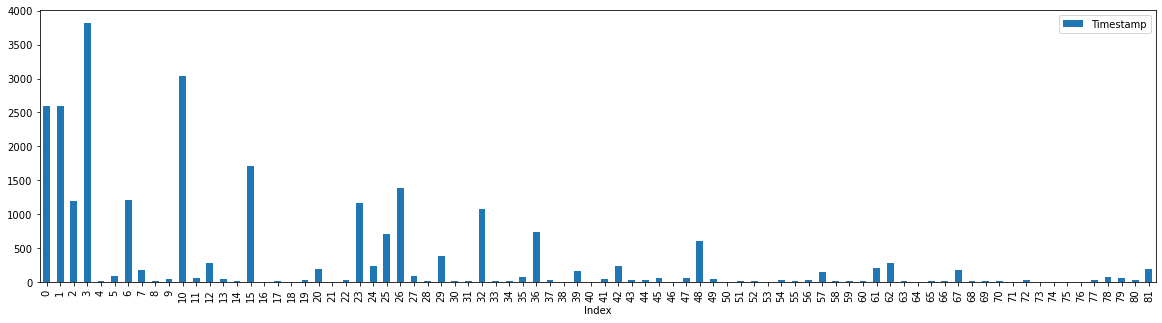

In [99]:
df.groupby("Index").count().plot(kind='bar', figsize=(20,5))


#### Data Visualization
Having the datasets is only the first part of the insights process. Tables are not human-friendly when you have a lot of different lines and columns. Using data visualization techniques (dataviz) is a more efficient way of understanding patterns, behaviors, etc.
First, let's define some default configurations for new figures:

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [123]:
plt.rcParams['figure.figsize'] = (20, 8)
sns.set()

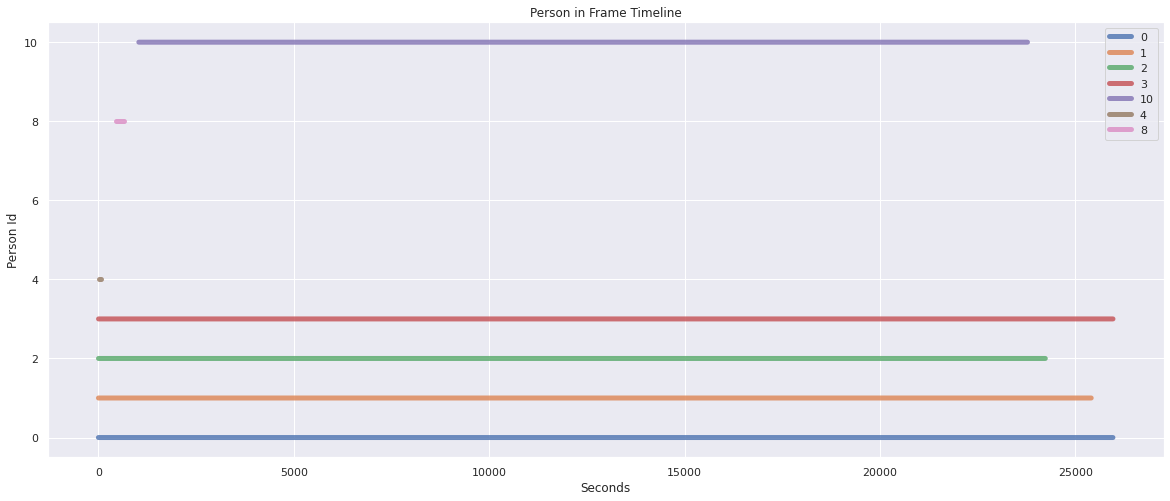

In [122]:
plt.rcParams['figure.figsize'] = (20, 8)
sns.set()

plt.figure(figsize=[20, 8])
selected = [0,1,2,3,10,4,8]
for idx in selected:
    plt.plot(df[df['Index']==idx]['Index'], label=idx, linewidth=5, alpha=0.8)
plt.legend()
plt.title('Person in Frame Timeline')
plt.xlabel('Seconds')
plt.ylabel('Person Id')
plt.show()